# Getting a Calibration for EDGES-3

To create a calibration object for EDGES-3 data, follow the general steps in this tutorial.

In [1]:
from edges_io import io3
from edges_io import TEST_DATA_PATH
from edges_cal import CalibrationObservation
from astropy import units as un
import matplotlib.pyplot as plt
import numpy as np
import warnings
import hickle

The first thing you need to know is the root directory where all the EDGES3 data is stored. On `enterprise`, this is `/data5/edges/data/EDGES3_data/MRO`. We have copied
a small little bit of that data (just calibration data) to this repo to be found at `TEST_DATA_PATH / edges3-mock-root`, so we can demonstrate the process here.

## Creating an I/O container

To create a particular calibration object, you need to also specify the date on which
the observations were taken:

In [2]:
ROOT = TEST_DATA_PATH / 'edges3-mock-root'
io_obs = io3.CalibrationObservation.from_date(
    root_dir=ROOT,
    year=2023,
    day=70,
)


The object we just created is simply a small container that holds the relevant files in
it, and *knows how to read them*. It doesn't do any modelling or calibration itself.

So, we can get out the files that we need:

In [3]:
for load, filedict in io_obs.s11_files.items():
    print(f"{load}:")

    for kind, fl in filedict.items():
        print(f"  {kind}: {fl.relative_to(ROOT)}")

ambient:
  input: 2023_070_11_amb.s1p
  open: 2023_070_11_O.s1p
  short: 2023_070_11_S.s1p
  match: 2023_070_11_L.s1p
hot_load:
  input: 2023_070_11_hot.s1p
  open: 2023_070_11_O.s1p
  short: 2023_070_11_S.s1p
  match: 2023_070_11_L.s1p
open:
  input: 2023_070_11_open.s1p
  open: 2023_070_11_O.s1p
  short: 2023_070_11_S.s1p
  match: 2023_070_11_L.s1p
short:
  input: 2023_070_11_short.s1p
  open: 2023_070_11_O.s1p
  short: 2023_070_11_S.s1p
  match: 2023_070_11_L.s1p
lna:
  input: 2023_070_11_lna.s1p
  open: 2023_070_11_lna_O.s1p
  short: 2023_070_11_lna_S.s1p
  match: 2023_070_11_lna_L.s1p


In [4]:
for load, fl in io_obs.acq_files.items():
    print(f"{load}: {fl.relative_to(ROOT)}")


ambient: mro/amb/2023/2023_070_12_43_06_amb.acq
hot_load: mro/hot/2023/2023_070_15_39_25_hot.acq
open: mro/open/2023/2023_070_18_35_43_open.acq
short: mro/short/2023/2023_070_21_32_02_short.acq


In [5]:
print(f"Temperature File: {io_obs.temperature_file.relative_to(ROOT)}")

Temperature File: temperature_logger/temperature.log


### Reading the data (not necessary)

You shouldn't normally need to use the reading methods directly -- that should be done
automatically when you create an `edges_cal.CalibrationObservation` object. However, 
here's how you would do it for each kind of data (spectra, S11 and temperature).

#### ACQ Files (Spectra)

In [6]:
amb_spectra = io_obs.get_spectra('ambient')

The result of this is a `FieldSpectrum`, which is not a super helpful object here, but it does contain the data:

In [7]:
type(amb_spectra.data)

/home/steven/work/edges/read_acq/src/read_acq/read_acq.py:184: UserWarning: In file /home/steven/work/edges/edges-io/src/edges_io/test_data/edges3-mock-root/mro/amb/2023/2023_070_12_43_06_amb.acq, item ;--output_file:
 has no value
  warnings.warn(f"In file {fname}, item {line} has no value")
/home/steven/work/edges/read_acq/src/read_acq/read_acq.py:184: UserWarning: In file /home/steven/work/edges/edges-io/src/edges_io/test_data/edges3-mock-root/mro/amb/2023/2023_070_12_43_06_amb.acq, item ;--stop_time:
 has no value
  warnings.warn(f"In file {fname}, item {line} has no value")


edges_io.h5.HDF5RawSpectrum

This data attribute holds several useful things, for example:

In [8]:
amb_spectra.data.keys()

<generator object _HDF5Part.keys at 0x7f418070cc10>

Text(0, 0.5, 'Q (ratio of powers)')

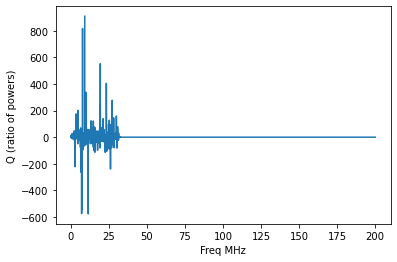

In [9]:
plt.plot(
    amb_spectra.data['freq_ancillary']['frequencies'], 
    np.mean(amb_spectra.data['spectra']['Q'], axis=1)
)
plt.xlabel("Freq MHz")
plt.ylabel("Q (ratio of powers)")


#### S11 Files

To read an S11 file, it's nicest to use the `SParams` object provided:

In [10]:
from edges_io.vna import SParams

In [11]:
s11 = SParams.from_s1p_file(io_obs.s11_files['lna']['input'])

Text(0, 0.5, '|S11|')

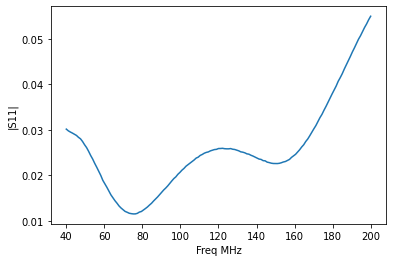

In [12]:
plt.plot(s11.freq.to_value("MHz"), np.abs(s11.s11))
plt.xlabel("Freq MHz")
plt.ylabel("|S11|")

#### Temperature

In [13]:
temps = io_obs.get_temperature_table()

/home/steven/work/edges/edges-io/src/edges_io/io3.py:124: UserWarning: Error parsing temperature log entry:
2023_069_06
Fri Mar 10 06:30:27 UTC 2023
0 +3.500000e+01
100 +3.783462e+01
101 +3.833843e+01
102 +1.236978e+02
sent 
 103 106 -2.917386e+01
150 +12.54
152 +1.675

  warnings.warn(str(e))


Note that the above error happens because of bad formatting in the file. The reader simply
ignores this entry and moves on, so you shouldn't worry about it.

The resulting table of information is an astropy `QTable`, so it has some nice features:

In [14]:
temps.info

<QTable length=827>
         name          dtype  unit  class  
--------------------- ------- ---- --------
                 time  object          Time
front_end_temperature float64    K Quantity
 amb_load_temperature float64    K Quantity
 hot_load_temperature float64    K Quantity
inner_box_temperature float64    K Quantity
      thermal_control float64        Column
      battery_voltage float64        Column
         pr59_current float64        Column

In [15]:
time_into_obs = temps['time'] - temps['time'][0]

In [16]:
np.any(np.isnan(temps['amb_load_temperature']))

False

In [17]:
from astropy.time import Time

In [18]:
start = Time(amb_spectra.data['time_ancillary']['times'][0,0], format='yday')
end = Time(amb_spectra.data['time_ancillary']['times'][-1, -1], format='yday')


In [19]:
start

<Time object: scale='utc' format='yday' value=2023:070:12:43:06.000>

In [20]:
end

<Time object: scale='utc' format='yday' value=2023:070:12:43:53.000>

In [21]:
temps['time'][1] - temps['time'][0]

<TimeDelta object: scale='tai' format='jd' value=0.003611111111111065>

In [22]:
0.003611111111111065 * 86400

311.999999999996

In [23]:
(temps['time'] > start) & (temps['time'] < end)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
start.jd

2460015.0299305557

In [25]:
io3.get_mean_temperature(temps, load='amb')

<Quantity 309.44815076 K>

Text(0, 0.5, 'Hot Load Temp [K]')

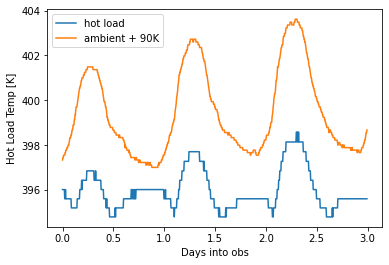

In [26]:
plt.plot(time_into_obs.jd, temps['hot_load_temperature'], label='hot load')
plt.plot(time_into_obs.jd, temps['amb_load_temperature'] + 90*un.K, label='ambient + 90K')

plt.legend()
plt.xlabel("Days into obs")
plt.ylabel("Hot Load Temp [K]")

## Creating the Calibration object

Now, to create a calibration object (that actually does calibration).

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    calobs = CalibrationObservation.from_edges3(
        io_obj = io_obs,
        f_low = 50*un.MHz,
        f_high = 100*un.MHz,
        spectrum_kwargs = {'default': {"allow_closest_time": True}}
    )


SPEC KWARGS:  {'default': {'allow_closest_time': True, 'freq_bin_size': 1}}
ALLOW CLOSEST TIME? True
ALLOW CLOSEST TIME? True
ALLOW CLOSEST TIME? True
ALLOW CLOSEST TIME? True


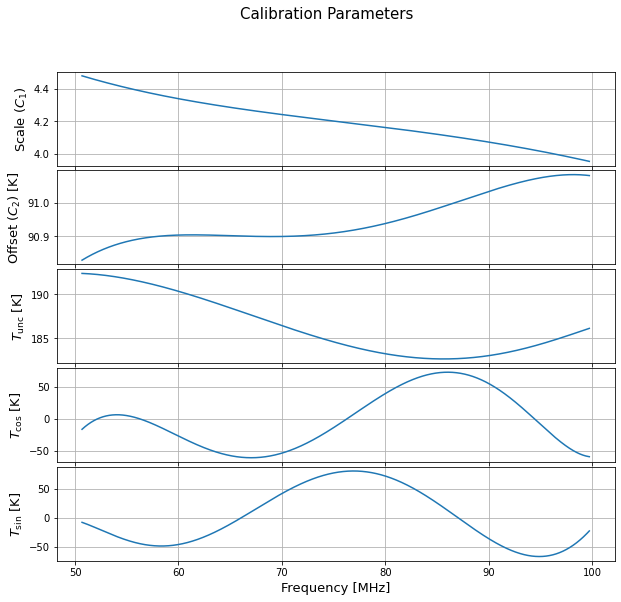

In [28]:
calobs.plot_coefficients();

To write out an object to be used by later analysis:

In [29]:
cal = calobs.to_calibrator()

In [31]:
hickle.dump(cal, 'myCal.h5')

/home/steven/miniconda3/envs/edges/lib/python3.10/site-packages/hickle/lookup.py:1491: SerializedWarning: 'poly1d' type not understood, data is serialized:
  warnings.warn(
/home/steven/miniconda3/envs/edges/lib/python3.10/site-packages/hickle/lookup.py:1491: SerializedWarning: 'method' type not understood, data is serialized:
  warnings.warn(
/home/steven/miniconda3/envs/edges/lib/python3.10/site-packages/hickle/lookup.py:1491: SerializedWarning: 'frozendict' type not understood, data is serialized:
  warnings.warn(
/home/steven/miniconda3/envs/edges/lib/python3.10/site-packages/hickle/lookup.py:1491: SerializedWarning: 'partial' type not understood, data is serialized:
  warnings.warn(


In [33]:
reloaded = hickle.load("myCal.h5")